In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', size=12)
plt.rc('axes', labelsize=12)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import gglngram as gn
import sqlite3 as sq

In [4]:
letter = 'c'
databasePath = 'data/database-%s.sqlite' % letter

In [5]:
dbconnection = sq.connect(databasePath)
cursor = dbconnection.cursor()

In [6]:
# Get sorted ngrams  by total counts
getTopNgram = """SELECT * from countngram
                 ORDER BY matchcount DESC"""

cursor.execute( getTopNgram )

rows = cursor.fetchall() 
print( len(rows) )

759511


In [7]:
# filter out ngram with '_':
rows = [ row for row in rows if '_' not in row[0] ]

print( len(rows) )

for row in rows[:10]:
    print(row)

322155
('ce', 368216698, 769114)
('cette', 214785748, 767827)
('comme', 201013050, 767738)
('ces', 174183859, 767094)
("c'est", 109613413, 761279)
("C'est", 64744571, 756701)
('contre', 63054389, 755491)
('Ce', 60242498, 763056)
('cas', 59620609, 738542)
('celle', 58825662, 758221)


In [30]:
def getZscore( years, counts ):
    iMax = np.argmax( counts )
    vMax = counts[ iMax ]
    zScore = (vMax - counts.mean())/counts.std()
    return years[ iMax ], zScore #* np.sqrt(counts.mean())

def getCumulScore( y, c ):
    cm = c.mean()
    cumul = np.cumsum( np.cumsum( (c - cm) ) )

    iMax = np.argmax( cumul )

    return y[ iMax ], cumul[iMax]


def getScore(y, c):
    ''' Return a year, and a score
    '''
    maxmin = c.max() - c.min()
    alpha = 0.1
    lowLimit = alpha*maxmin + c.min()
    highLimit = c.max() - alpha*maxmin

    unknownLimit = 0.00001
    unknownDuration = len( np.argwhere( c<unknownLimit ) )
    
                          
    yearsInTheMiddle = y[ np.argwhere( (c>lowLimit) & (c<highLimit)  ) ]
    dt = len( yearsInTheMiddle )
    puissance = maxmin / dt
    #yMiddle = int( yearsInTheMiddle.mean() )
    yMiddle = y[ np.argwhere( c>lowLimit )[0][0] ]
    
    #p = np.diff(c)/c[1:]
    #p = p[ (c[1:])>1e-2 ]

    if unknownDuration < 3:
        puissance = 0
        
    return yMiddle, puissance


def getScoreOpti(y, c):
    ''' Return a year, and a score
    '''
    unknownLimit = 0.00001
    if c.min() > unknownLimit or c.sum() < 1e-5:
        yStart, puissance = 0, 0
        
    else:
        cmax = c.max()
        alpha = 0.1
        lowLimit = alpha*cmax
        #highLimit = cmax*( 1 - alpha )


        #inTheMiddle = np.argwhere( (c>lowLimit) & (c<highLimit)  )
        #dt = len( inTheMiddle )
        puissance = cmax #/ dt

        yStart = y[ np.argwhere( c>lowLimit )[0][0] ]
        
    return yStart, puissance

In [31]:
scoreByYear = {}
i = 0
for ng, c, ngs in rows[:6000]:
    year, zScore = getScoreOpti( *gn.getCountPerYear( cursor, ng, k=3, volume=False, normed=True ) )
    
    if zScore != 0:
    
        if year in scoreByYear:
            scoreByYear[year].append( [ng, zScore] )
        else:
            scoreByYear[year] = [ [ng, zScore], ]
        
    i = i + 1
    if i%50==0:
        print( '\r %i'%i, end='' )
        
print('\n done')

 6000
 done


In [32]:
# save output to JSON:
import json
scoreByYear_str = { str(key):value for key, value in scoreByYear.items() }
json.dump(scoreByYear_str, open("results/timeline_20k_%s.json" % letter, 'w'))

In [33]:
getTop5 = lambda l: ', '.join([ x[0] for x in sorted( l, key=lambda x:x[1], reverse=True )[:7] ])

In [34]:
scoreByYearList = sorted( scoreByYear.items(), key=lambda x:x[0] )
scoreByYearList = [ '%i: %s'%(y, getTop5(ngrams)) for y, ngrams in  scoreByYearList ]

In [35]:
print( '\n'.join(scoreByYearList) )

1801: cit, cellules, chaux, Convention, Compagnie, conception, créanciers
1802: Cour, Claude, capitalistes, Classe, Christian, cy, contemporain
1803: communautés, changements, Ch., Cabinet, Canal, conjoncture, conscrits
1804: compétence, couple, cellule, clé, Collège, Cass, culpabilité
1805: coefficient, can, consultation, Charette, contentieux, crânes, Chouans
1806: Commune, constate, courants, contraintes, candidat, Corinne, civ
1807: chiffre, commerciale, céréales, Confédération, Comptes, Comm, Comédie
1808: Chambres, Communautés, case, composantes, congrégations, Cruz, Croatie
1809: Côte, corpus, Chemins, Colin, complété, Concours, COMMISSION
1810: classiques, croup, classement, Cl., contrôles, Création, chascun
1811: Chambre, clinique, client, collaborateurs, Chateaubriand, constituait, Coran
1812: contacts, coefficients, chantier, Carter, calorimètre, Caulaincourt, Chanson
1813: Charte, chlorure, coloniale, chlore, Caisse, commerciaux, cortès
1814: crise, Cromwell, Civ, cerner, c

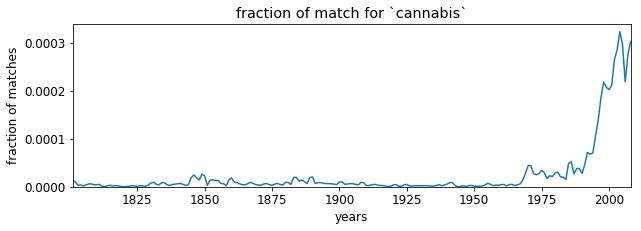

In [37]:
gn.plot( cursor, "cannabis", k=3, volume=False, normed=True )

In [146]:
y, c = gn.getCountPerYear( cursor,  "ruralité.", k=3, volume=False, normed=True )

In [147]:
c.sum()

9.808761763310659e-06

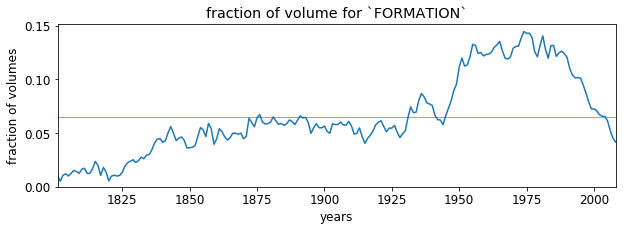

In [102]:
gn.plot( cursor, "FORMATION", k=3, volume=True, normed=True )

In [71]:
getScore( *gn.getCountPerYear( cursor, 'fonctionnelle', k=3, volume=True, normed=True ) )

(1846, 0.0026611465175493732)